In [28]:
import tensorflow as tf
import glob
import os

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

train_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_train\*.png"))
seg_train_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_seg_train\*.png"))

test_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_test\*.png"))
seg_test_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_seg_test\*.png"))

val_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_validate\*.png"))
seg_val_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_seg_validate\*.png"))

In [64]:
train = tf.data.Dataset.from_tensor_slices(train_dir)
test = tf.data.Dataset.from_tensor_slices(test_dir)
val = tf.data.Dataset.from_tensor_slices(val_dir)

train = train.shuffle(len(train_dir))
test = test.shuffle(len(test_dir))
val = val.shuffle(len(val_dir))

def process_path(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 1)
    img = tf.image.resize(img, (256,256))
    img = tf.cast(img, tf.float32) - 127.5
    img = img / 127.5

    return img

train = train.map(process_path)
test = test.map(process_path)
val = val.map(process_path)

train_count = 0
test_count = 0

# for i in train:
#     train_count += 1
# for i in test:
#     test_count += 1
    
print(train, test, "Train Count: ", train_count, "Test Count: ", test_count)

<MapDataset shapes: (256, 256, 1), types: tf.float32> <MapDataset shapes: (256, 256, 1), types: tf.float32> Train Count:  0 Test Count:  0


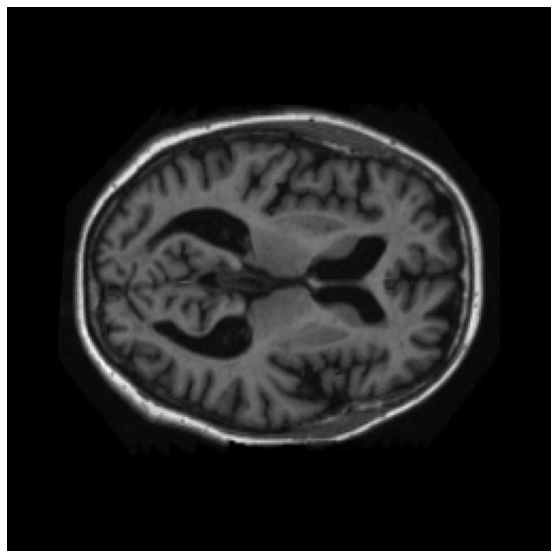

In [65]:
import matplotlib.pyplot as plt 

def display(images):
    plt.figure(figsize=(10,10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i], cmap = 'gray')
        plt.axis('off')
    plt.show()
    
for img in train.take(1):
    display([tf.squeeze(img)])

In [66]:
from tensorflow.keras import layers

image_res = (256,256)

def make_generator_model():
    model = tf.keras.Sequential()
        
    model.add(layers.Dense(image_res[0] // 8 * image_res[1] // 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((image_res[0] // 8, image_res[1] // 8, 256)))
    
    assert model.output_shape == (None, image_res[0] // 8, image_res[1] // 8, 256)

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    
    assert model.output_shape == (None, image_res[0] // 4, image_res[1] // 4, 128)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    
    assert model.output_shape == (None, image_res[0] // 2, image_res[1] // 2, 64)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    assert model.output_shape == (None, image_res[0], image_res[1], 1)
    
#     model.summary()
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[image_res[0], image_res[1], 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    opt = tf.keras.optimizers.Adam(1e-4)
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
#     model.summary()
    return model

In [67]:
generator = make_generator_model()
discriminator = make_discriminator_model()

def generator_loss(fake_output):
    
    return tf.keras.losses.BinaryCrossentropy(tf.ones_like(fake_output), fake_output)

# noise = tf.random.normal([1, 100])
# generated_image = generator(noise, training=False)
# plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# discriminator = make_discriminator_model()
# decision = discriminator(generated_image)

# print (decision)